# Variational Autoencoders
#### [Auto-Encoding Variational Bayes - Kingma and Welling, 2013](https://arxiv.org/abs/1312.6114)
Efficient inference and learning in a directed probabilistic model, in the presence of latent variables with an intractable posterior distribution over large datasets.

This work is absolutely not an effort to reproduce exact results of the cited paper, nor I confine my implementations to suggestion of the original authors. With this implementation I aim to widen my own understanding of the original work. Use this code with no warranty and please respect the accompanying license.

In [9]:
# Imports
%reload_ext autoreload
%autoreload 1

import os, sys
sys.path.append('../')
sys.path.append('../common')
sys.path.append('../GenerativeModels')

from tools_general import tf, np
from IPython.display import Image
from tools_train import get_train_params, OneHot, vis_square
from tools_config import data_dir
from tools_train import get_train_params, plot_latent_variable
import matplotlib.pyplot as plt
import imageio
from tensorflow.examples.tutorials.mnist import input_data

In [2]:
# define parameters
networktype = 'VAE_MNIST'

work_dir = '../trained_models/%s/' %networktype
if not os.path.exists(work_dir): os.makedirs(work_dir)

## Network definitions

In [3]:
from VAE import create_encoder, create_decoder, create_vae_trainer

# Training VAE
You can either get the fully trained models from [my google drive](https://goo.gl/7PrKD2) or train your own models using the VAE.py script

## Evolution of the latent variable during the training phase
Evolution of approximate posterior Q(z|X) and likelihood P(X|z) during training with 2D latent space.

In [ ]:
# batch_size = 128
# base_lr = 1e-5
# epochs = 30
# latendD = 2
# spl = 200 #sample_per_label

# data, max_iter, test_iter, test_int, disp_int = get_train_params(data_dir + '/' + networktype, batch_size, epochs=epochs,one_hot=False, test_in_each_epoch=1, networktype=networktype)
# all_test_set, all_labels = data.test.next_batch(data.test.num_examples)

# Xtest = np.zeros([spl*10, 28,28,1])
# Xlabel = np.zeros([spl*10, 1])
# for num in range(10):
#     Xtest[spl*num:spl*num+spl,:] = all_test_set[np.where(all_labels==num)[0]][0:spl]
#     Xlabel[spl*num:spl*num+spl,:] = num
# Xlabel_onehot = OneHot(Xlabel.astype(np.int32))

# Z_test = np.random.normal(size=[spl*10, latendD], loc=0.0, scale=1.).astype(np.float32)

# num_colors = ['C0.','C1.','C2.','C3.','C4.','C5.','C6.','C7.','C8.','C9.']

In [ ]:
# tf.reset_default_graph() 
# with tf.Session() as sess:
#     vaetrain, total_loss, is_training, inZ, inX, inL, Xrec, Qmu = create_vae_trainer(base_lr, networktype=networktype, latendD=latendDim)
#     tf.global_variables_initializer().run()

#     test_int = 20
#     best_test_loss = np.inf 

#     images = []

#     for it in range(max_iter): 
#         Z = np.random.normal(size=[batch_size, latendDim], loc=0.0, scale=1.).astype(np.float32)

#         if it == 2 or it % test_int == 0:
#             accumulated_loss = 0.0 
#             for i_test in range(test_iter):
#                 X, labels = data.test.next_batch(batch_size)
#                 recloss = sess.run(total_loss, feed_dict={inX:X, inL:np.zeros([batch_size,10]), inZ: Z, is_training:False})
#                 accumulated_loss = np.add(accumulated_loss, recloss)

#             cur_test_loss = np.divide(accumulated_loss, test_iter)
#             if cur_test_loss < best_test_loss:
#                 best_test_loss = cur_test_loss
#                 [Qmu_cur,Xrec_cur] = sess.run([Qmu,Xrec], feed_dict={inX:Xtest, inL:Xlabel_onehot, inZ: Z_test, is_training:False})
#                 fname = work_dir+ 'Iter_%d.jpg'%it
#                 fig = plt.figure(figsize=(10,5))
#                 fig.suptitle('Iter. #%d, Test_loss = %1.5f'%(it,best_test_loss))
#                 likelihood = np.zeros([100, 28, 28, 1])
#                 for num in range(10):
#                     ax1 = fig.add_subplot(121)
#                     ax1.plot(Qmu_cur[np.where(Xlabel==num)[0],0],Qmu_cur[np.where(Xlabel==num)[0],1],num_colors[num], label='%d'%num)
#                     likelihood[np.arange(0,100,10)+num] = Xrec_cur[np.where(Xlabel==num)[0][:10]]
#                     #print(np.arange(0,100,10)+num)
#                 ax1.legend(loc='upper right', bbox_to_anchor=(1.1, 1.05), ncol=1, fancybox=True, shadow=True)
#                 ax1.set_xlabel('Latent Dimension #1');ax1.set_ylabel('Latent Dimension #2')
#                 ax1.set_ylim([-7,7]);ax1.set_xlim([-7,7])

#                 ax2 = fig.add_subplot(122)
#                 ax2.imshow(vis_square(likelihood, [10, 10]), cmap='gray')
#                 ax2.set_xticks([])
#                 ax2.set_yticks([])

#                 plt.savefig(fname, dpi=300)
#                 plt.close()
#                 images.append(imageio.imread(fname))


#         if it % (disp_int*100) == 0:print('-- It. %0.4d Best Results yet.[loss = %2.5f] saving results...' % (it,best_test_loss))

#         X, labels = data.train.next_batch(batch_size)
#         recloss, _ = sess.run([total_loss, vaetrain], feed_dict={inX:X, inL:np.zeros([batch_size,10]), inZ: Z, is_training:True})

#     imageio.mimsave(work_dir+'posterior_likelihood_evolution.gif', images)

In [4]:
Image(url=work_dir+'posterior_likelihood_evolution.gif') 

Visualization of the 2D latent variable corresponding to a Convolutional Variational Autoencoder during training on MNIST dataset (handwritten digits). The image to the left is the mean of the approximate posterior Q(z|X) and each color represents a class of digits within the dataset. The image to the left shows samples from the decoder (likelihood) P(X|z). The title above shows the iteration number and total loss [Reconstruction + KL] of the model at the point that images below were produced from the model under training. One can observe that by the time the generated outputs (left image) get better, the points on the latent space (posterior) also get into better seperated clusters. Also note that points get closer to each other because the KL part of the total loss is imposing a zero mean gaussian distribution on the latent variable, which is realized on the latent variable as the trainig proceeds.

# Experiments
Create demo networks and restore weights

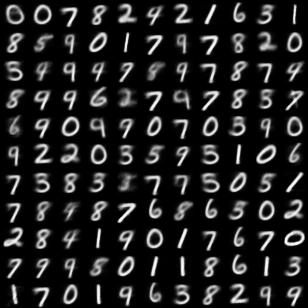

In [5]:
best_model = work_dir + "080_34749_model.ckpt"
best_img = work_dir + 'Epoch_080_Iter_34749.jpg'
Image(filename=best_img)

In [8]:
latentD = 2 # of the best model trained
batch_size = 128

tf.reset_default_graph() 
demo_sess = tf.InteractiveSession()

is_training = tf.placeholder(tf.bool, [], 'is_training')

Zph = tf.placeholder(tf.float32, [None, latentD])
Xph = tf.placeholder(tf.float32, [None, 28, 28, 1])

posteriorMu_op, posteriorSigma_op = create_encoder(Xph, is_training, latentD, reuse=False, networktype=networktype + '_Enc') 
Z_op = posteriorSigma_op * Zph + posteriorMu_op
Xrec_op = create_decoder(Z_op, is_training, latentD, reuse=False, networktype=networktype + '_Dec')
    
tf.global_variables_initializer().run()

Enc_varlist = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=networktype + '_Enc')    
Dec_varlist = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=networktype + '_Dec')
saver = tf.train.Saver(var_list=Enc_varlist+Dec_varlist)
saver.restore(demo_sess, best_model)

Extracting ../data/train-images-idx3-ubyte.gz
Extracting ../data/train-labels-idx1-ubyte.gz
Extracting ../data/t10k-images-idx3-ubyte.gz
Extracting ../data/t10k-labels-idx1-ubyte.gz


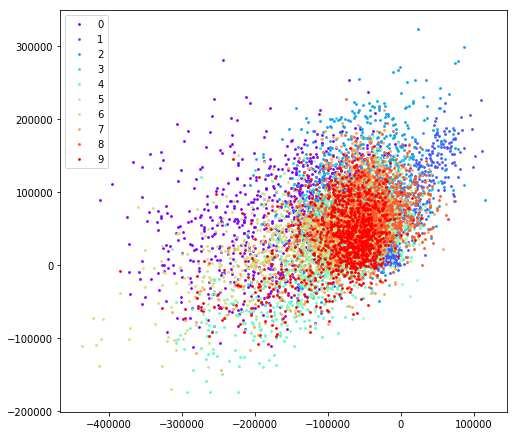

In [12]:
data = input_data.read_data_sets(data_dir, one_hot=False, reshape=False)
test_data, test_labels = data.test.next_batch(data.test.num_examples)
decoded_data = demo_sess.run(posteriorMu_op, feed_dict={Xph:test_data, is_training:False})
plot_latent_variable(decoded_data, test_labels)

### Generate new data
Approximate samples from the posterior distribution over the latent variables p(z|x)

In [ ]:
Z_test = np.random.normal(size=[batch_size, latendDim], loc=0.0, scale=1.).astype(np.float32)
labels_test = OneHot(np.random.randint(10, size=[batch_size]), n=10)    

vaeD_sample = demo_sess.run(Xrec, feed_dict={inL:labels_test, inZ: Z_test , is_training:False})
vis_square(vaeD_sample[:121], [11, 11], save_path=work_dir + 'sample.jpg')
Image(filename=work_dir + 'sample.jpg')

notice that our current model is not conditioned and basically we cannot generate exactly from whatever classes we want. That will be fixed in the Conditioned Variational Auto Encoders [Semi-Supervised Learning with Deep Generative Models](https://arxiv.org/abs/1406.5298).